In [25]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.layers import Input, Dense, GlobalMaxPooling1D
from keras.layers import LSTM, Embedding, MaxPool1D, GRU
from keras.models import Model
from sklearn.metrics import roc_auc_score

In [26]:
import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU

In [27]:
EMBEDDING_DIM = 100
VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 100
VALIDATION_SPLIT = 0.2
EPOCHS = 5
BATCH_SIZE = 32

In [28]:
print('Loading Glove word vectors...')
with open('D:\Downloads\glove.6B\glove.6B.%sd.txt' % EMBEDDING_DIM, 'r', encoding="utf8") as f:
    word2vec = {}
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec

Loading Glove word vectors...


In [29]:
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [30]:
print('Loading in comments...')
train = pd.read_csv('D:/Downloads/jigsaw-toxic-comment-classification-challenge/train.csv')
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

Loading in comments...


In [31]:
print('Tokenizing comments...')
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

Tokenizing comments...


In [32]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

Found 210337 unique tokens.


In [33]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor', data.shape)

Shape of data tensor (159571, 100)


In [34]:
print('Sequences:')
print(data[:3])

Sequences:
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0   688    75     1   126   130   177    29
    672  4511 12052  1116    86   331    51  2278 11448    50  6864    15
     60  2756   148     7  2937    34   117  1221 15190  2825     4    45
     59   244     1   365    31     1    38    27   143    73  3462    89
   3085  4583  2273   985]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0


In [35]:
print('Creating embedding matrix...')
num_words = min(VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
    if i < VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Creating embedding matrix...


In [36]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

In [37]:
print('Building model...')

input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = LSTM(15, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)

output = Dense(len(possible_labels), activation='sigmoid')(x)

Building model...


In [38]:
model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(lr=0.01),
  metrics=['accuracy']
)

In [39]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Train on 127656 samples, validate on 31915 samples
Epoch 1/5
127656/127656 [==============================] - 73s 573us/step - loss: 0.0657 - acc: 0.9780 - val_loss: 0.0588 - val_acc: 0.9795
Epoch 2/5
127656/127656 [==============================] - 72s 568us/step - loss: 0.0565 - acc: 0.9802 - val_loss: 0.0566 - val_acc: 0.9801
Epoch 3/5
127656/127656 [==============================] - 72s 564us/step - loss: 0.0552 - acc: 0.9807 - val_loss: 0.0558 - val_acc: 0.9802
Epoch 4/5
127656/127656 [==============================] - 71s 559us/step - loss: 0.0540 - acc: 0.9808 - val_loss: 0.0545 - val_acc: 0.9809
Epoch 5/5
127656/127656 [==============================] - 73s 570us/step - loss: 0.0531 - acc: 0.9811 - val_loss: 0.0548 - val_acc: 0.9807


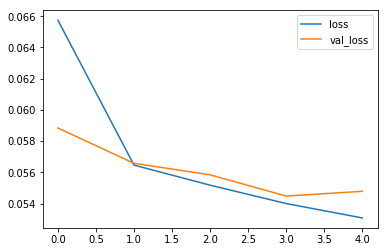

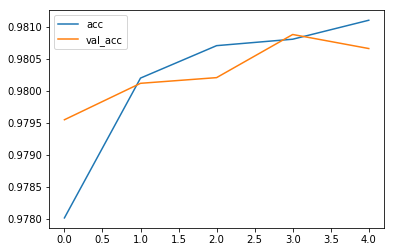

In [40]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [41]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

0.975084201874
